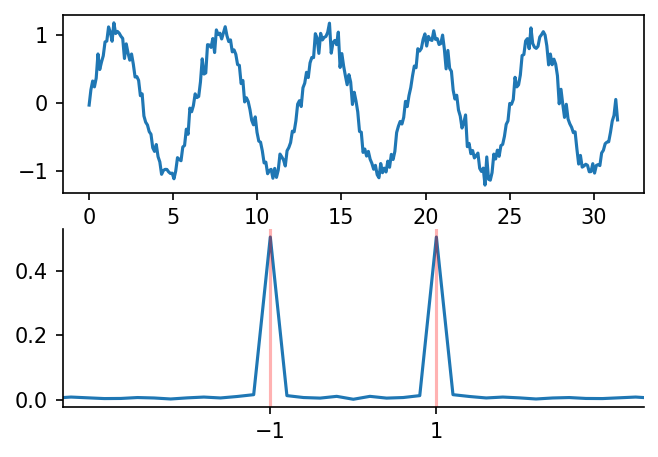

In [1]:
import numpy as np
import recycle as re
import matplotlib.pyplot as plt
from ripser import Rips
from persim import plot_diagrams
from scipy.linalg import svdvals

x = np.linspace(0, 10 * np.pi, 300)
fx = np.sin(x) + np.random.normal(0, 0.1, size=(x.shape))

mosaic = """
A
B
"""

freqs, coefs, peaks = re.timeseries.find_frequency_peaks(
    fx, x, min_height=0.1, distance=1
)
fig, ax = plt.subplot_mosaic(mosaic, figsize=(5, 3.4), dpi=150)
ax["A"].plot(x, fx)
re.timeseries.plot_frequency_peaks(freqs, coefs, peaks, ax["B"])
ax["B"].set_xlim(-3.5, 3.5)
plt.show()

# delays
rate = 10 * np.pi / 300
delays = np.linspace(0, 45 * rate, 100)
average_orth = [re.timeseries.gamma_value(tau, freqs[peaks]) for tau in delays]
min_delay = delays[np.argmin(average_orth)]
delay = int(min_delay // rate)


vandermond = re.timeseries.omega_matrix(min_delay, freqs[peaks])
sigma = svdvals(vandermond)
f_approx = re.timeseries.reconstruct_signal(coefs, peaks)
diff = np.abs(fx - f_approx)
lower_bound = np.sqrt(3) * np.max(np.abs(coefs[peaks])) * np.min(sigma) - np.sqrt(
    np.sum(peaks) + 1
) * np.max(diff)

# embedding
embedding = re.timeseries.time_delay_embedding(fx, dimension=np.sum(peaks), delay=delay)


Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


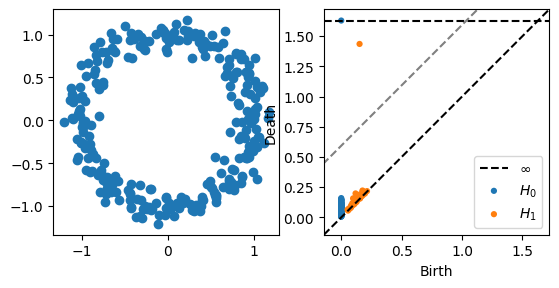

In [2]:
### TDA STUFF

mosaic = "AB"
fig, ax = plt.subplot_mosaic(mosaic)
ax["A"].scatter(embedding[:, 0], embedding[:, 1])
ax["A"].axis("square")

rips = Rips()
diags = rips.fit_transform(embedding)
plot_diagrams(diags, ax=ax["B"])
b_values = np.linspace(-10, 5, 15)
# Calculate y values for the line at a distance of 0.2 from the line x=y
d_values = b_values + lower_bound
# Plot the line x=y for reference
ax["B"].plot(b_values, d_values, linestyle="--", color="gray", label="x=y")
plt.show()



In [8]:
def time_adjacency_matrix():
    def inner_time_adjacency_matrix(simplex_j, simplex_i):
        if are_simplices_adjacent(simplex_j, simplex_i):
            return time_weight(simplex_i, simplex_j)
        else:
            return 0

    return inner_time_adjacency_matrix

def time_label(simplex_i):
    return np.mean(simplex_i)

def time_weight(simp1, simp2) -> float:
    return np.abs(time_label(simp1) - time_label(simp2))

def are_simplices_adjacent(simplex1, simplex2):
    # Count common elements between the two tuples
    common_elements = set(simplex1).intersection(set(simplex2))
    # Two simplices are adjacent if they share exactly n-1 elements
    if len(common_elements) == len(simplex1) - 1:
        return 1
    return 0


def time_basic_matrix(
    inv_row_map,
) -> np.ndarray:
    n = len(inv_row_map)
    weight_matrix = np.zeros((n, n))

    for i in range(n):
      simplex_i = inv_row_map[i]
      weight_matrix[i,i] = np.abs(simplex_i[0]-simplex_i[1])
    return weight_matrix

In [7]:
# get all cycles bigger than the given bound
persistence = diags[1][:, 1] - diags[1][:, 0]
cycles = np.argwhere(persistence > lower_bound).flatten()
birth, death = diags[1][cycles[0]]
# use death to calculate max_edge_length
max_edge_length = death * 1.01  # give a bit of slack

dimension = 2
points = embedding
min_persistence = lower_bound
#min_persistence = 0.4


gudhi_complex = re.core.create_simplicial_complex(points, max_edge_length, dimension)
(
    representative,
    boundary_map,
    reduced_boundary_base,
    (birth_simplex,death_simplex)
) = re.core.get_representative_and_complex(gudhi_complex, dimension)

# Get the ACTUAL values of birth and death
birth,death = gudhi_complex.filtration(birth_simplex),gudhi_complex.filtration(death_simplex)

order_function = lambda s: (gudhi_complex.filtration(s), s)
# ISOLATED
np1_simplices = sorted(
    {
        simplex
        for simplex in reduced_boundary_base
        if gudhi_complex.filtration(simplex) <= (death - min_persistence)*1.01 #slack for rounding errors
    },
    key=order_function,
)
n_simplices = sorted(
    {
        tuple(sorted(simplex))
        for simplex, radius in gudhi_complex.get_filtration()
        if len(simplex) == dimension and radius <= (death - min_persistence)*1.01 #slack for rounding errors
    },
    key=order_function,
)
nm1_simplices = sorted(
    {
        tuple(sorted(simplex))
        for simplex, radius in gudhi_complex.get_filtration()
        if len(simplex) == dimension - 1 and radius <= (death - min_persistence)*1.01 #slack for rounding errors
    },
    key=order_function,
)
        
x_orig = re.core.lift_representative(representative, nm1_simplices, n_simplices)
boundary_matrix = re.core.build_boundary_matrix(n_simplices, np1_simplices)

In [ ]:
W = re.core.create_weight_matrix(n_simplices, time_adjacency_matrix())
#W = None

# Run optimization
x_min, status, objective_value = re.core.find_minimal_homologous_cycle(
    boundary_matrix, x_orig, W, use_gurobi=True
)
print("Objective value (L1 norm of x):", objective_value)
min_cycle = set(
    [n_simplices[index] for index in np.argwhere(~np.isclose(x_min, 0)).flatten()]
)  # be carefull here with values close to zero, add a tolerance parameter


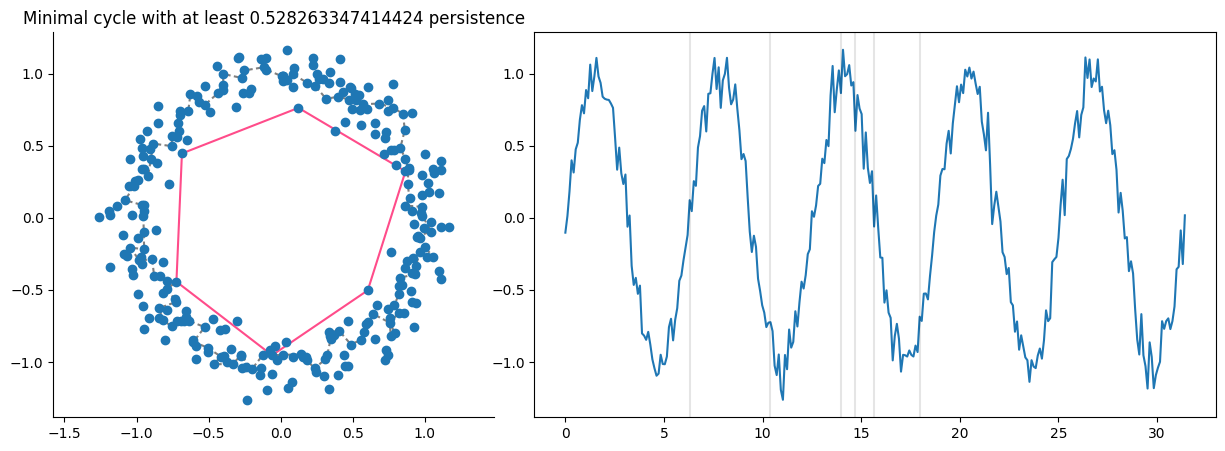

In [106]:

fig, ax = plt.subplot_mosaic("AABBB",figsize=(15,5))

for edge in representative:
    ax["A"].plot(*zip(points[edge[0]], points[edge[1]]), "--", color="k", alpha=0.5)
for edge in min_cycle:
    ax["A"].plot(*zip(points[edge[0]], points[edge[1]]), "-", color="#FF0059", alpha=0.7)
ax["A"].plot([], [], "--", color="k", alpha=0.5, label="Initial Representative")
ax["A"].plot([], [], "-", color="#FF0059", label=f"Minimal @ {min_persistence}")
ax["A"].plot(*zip(*points), "o")
#ax["A"].legend()
ax["A"].axis("equal")
ax["A"].spines[["right", "top"]].set_visible(False)
ax["A"].set_title(f"Minimal cycle with at least {min_persistence} persistence")


vertex_set = {item for tup in min_cycle for item in tup}
ax["B"].plot(x, fx)
for vertex in vertex_set:
    ax["B"].axvline(x[vertex], color="k", alpha=0.1)
plt.show()


In [107]:
W = time_basic_matrix(n_simplices)
x_alt, status, objective_value = re.core.find_minimal_homologous_cycle(boundary_matrix, x_orig,W,use_gurobi=False) 
alt_cycle = set([n_simplices[index] for index in np.argwhere(~np.isclose(x_alt,0)).flatten()])

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/miniconda3/envs/recycle/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/n0/wk41mth910n6jkj_vdp1m4z00000gn/T/71a03e5637ad4e36b560524e48f6c376-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/n0/wk41mth910n6jkj_vdp1m4z00000gn/T/71a03e5637ad4e36b560524e48f6c376-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11723 COLUMNS
At line 92895 RHS
At line 104614 BOUNDS
At line 116048 ENDATA
Problem MODEL has 11718 rows, 34869 columns and 57735 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 7820 (-3898) rows, 30971 (-3898) columns and 56379 (-1356) elements
Perturbing problem by 0.001% of 250 - largest nonzero change 0.00099941292 ( 0.070116966%) - largest zero change 0
0  Obj 0 Primal inf 3.5468549 (104)
231  Obj 0 Primal inf 0.99625598 (184)
462  Obj 0 Primal in

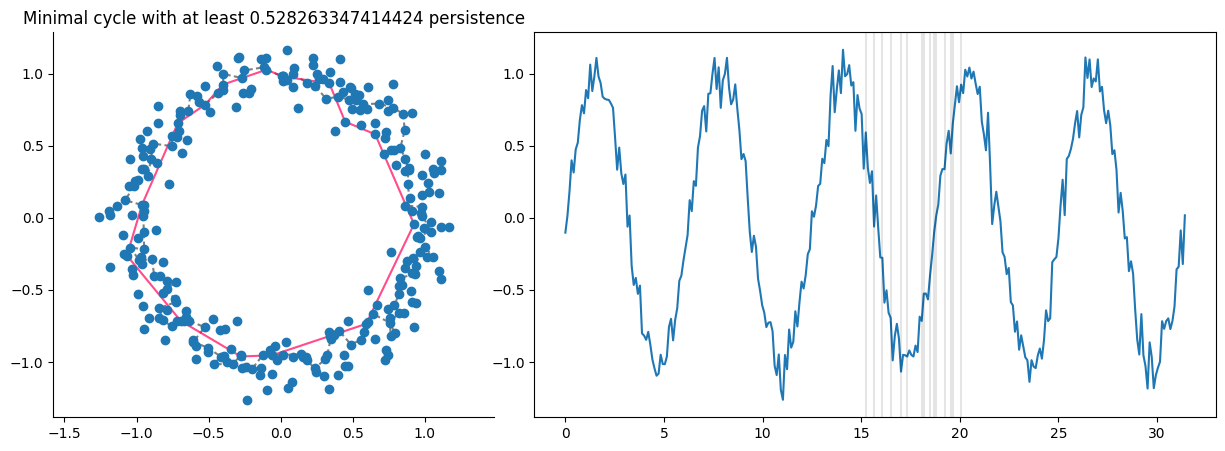

In [108]:

fig, ax = plt.subplot_mosaic("AABBB",figsize=(15,5))

for edge in representative:
    ax["A"].plot(*zip(points[edge[0]], points[edge[1]]), "--", color="k", alpha=0.5)
for edge in alt_cycle:
    ax["A"].plot(*zip(points[edge[0]], points[edge[1]]), "-", color="#FF0059", alpha=0.7)
ax["A"].plot([], [], "--", color="k", alpha=0.5, label="Initial Representative")
ax["A"].plot([], [], "-", color="#FF0059", label=f"Minimal @ {min_persistence}")
ax["A"].plot(*zip(*points), "o")
#ax["A"].legend()
ax["A"].axis("equal")
ax["A"].spines[["right", "top"]].set_visible(False)
ax["A"].set_title(f"Minimal cycle with at least {min_persistence} persistence")


vertex_set = {item for tup in alt_cycle for item in tup}
ax["B"].plot(x, fx)
for vertex in vertex_set:
    ax["B"].axvline(x[vertex], color="k", alpha=0.1)
plt.show()


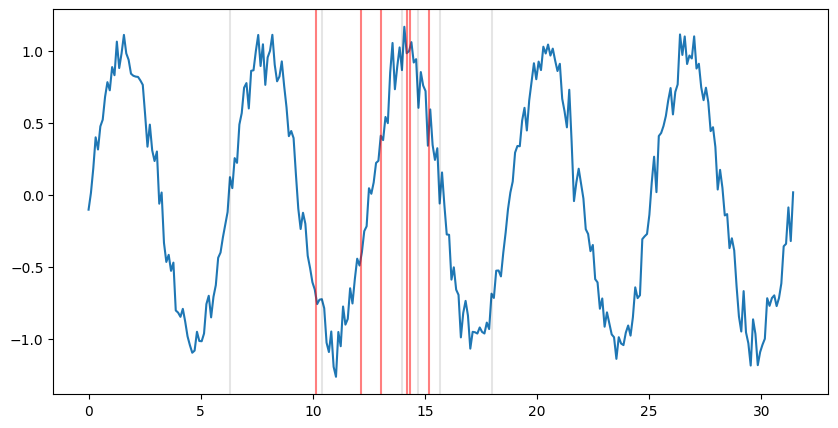

In [122]:

plt.figure(figsize=(10,5))
vertex_set = {item for tup in min_cycle for item in tup}
plt.plot(x, fx)
for vertex in vertex_set:
    plt.axvline(x[vertex], color="k", alpha=0.1)
for s in min_cycle:
    plt.axvline(np.mean([x[s[0]],x[s[1]]]), color="r", alpha=0.5)
plt.show()


In [100]:
np.sum([np.abs(s[0]-s[1]) for s in alt_cycle])

np.int64(82)

In [101]:
np.sum([np.abs(s[0]-s[1]) for s in min_cycle])

np.int64(90)

In [115]:
time_label(simplex)

np.float64(135.0)